<a href="https://colab.research.google.com/github/srita2003/Fake_News_Detection_using_Graph-Attention-Networks-GAT-and-BERT-embeddings-/blob/main/Fake_news_detection_using_GAT_and_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip uninstall -y torch-scatter torch-sparse torch-cluster torch-geometric torch-spline-conv

!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.1.0+cpu.html

import torch_geometric
print(f"Torch Geometric version: {torch_geometric.__version__} (Successfully Installed!)")


Looking in links: https://data.pyg.org/whl/torch-2.1.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.4/500.4 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.3/210.3 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.5 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOp

Torch Geometric version: 2.6.1 (Successfully Installed!)


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_add_pool
from sklearn.metrics import accuracy_score
import numpy as np
import os

# 1. Load Dataset
dataset_name = 'gossipcop'
feature_type = 'bert'
edge_type = 'graph'
root = './data'

train_dataset = UPFD(root=root, name=dataset_name, feature=feature_type,
                     split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature_type,
                   split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature_type,
                    split='test')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Extracting data/gossipcop/raw/data.zip
Processing...
Done!


In [ ]:
# 2. Define GAT Model
class CATGATImproved(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(CATGATImproved, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=4, concat=True, dropout=0.2)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels * 4)

        self.gat2 = GATConv(hidden_channels * 4, hidden_channels, heads=4, concat=True, dropout=0.2)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels * 4)

        self.gat3 = GATConv(hidden_channels * 4, hidden_channels, heads=1, concat=False, dropout=0.2)
        self.bn3 = torch.nn.BatchNorm1d(hidden_channels)

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(hidden_channels, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(64, num_classes)
        )

    def forward(self, x, edge_index, batch):
        x = F.relu(self.bn1(self.gat1(x, edge_index)))
        x = F.relu(self.bn2(self.gat2(x, edge_index)))
        x = F.relu(self.bn3(self.gat3(x, edge_index)))
        x = global_add_pool(x, batch)
        return self.classifier(x)


In [ ]:
# 3. Train Function
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

In [ ]:
# 4. Evaluate Function
def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            y_true.append(data.y.cpu())
            y_pred.append(pred.cpu())
    y_true = torch.cat(y_true)
    y_pred = torch.cat(y_pred)
    return accuracy_score(y_true, y_pred)

In [ ]:
# 5. Setup & Hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
in_channels = train_dataset.num_features
num_classes = 2

model = CATGATImproved(in_channels=in_channels, hidden_channels=64, num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5)


In [ ]:
# 6. Training Loop with Early Stopping
best_val_acc = 0
patience = 10
counter = 0

for epoch in range(100):
    train_loss = train(model, train_loader, optimizer, criterion)
    val_acc = evaluate(model, val_loader)
    scheduler.step(val_acc)

    print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_catgat_model.pt")  # Save the model
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

Epoch: 1, Train Loss: 2.1313, Val Accuracy: 0.6209
Epoch: 2, Train Loss: 0.9937, Val Accuracy: 0.7253
Epoch: 3, Train Loss: 0.5601, Val Accuracy: 0.7473
Epoch: 4, Train Loss: 0.4383, Val Accuracy: 0.7436
Epoch: 5, Train Loss: 0.3628, Val Accuracy: 0.6282
Epoch: 6, Train Loss: 0.2813, Val Accuracy: 0.7015
Epoch: 7, Train Loss: 0.2091, Val Accuracy: 0.7949
Epoch: 8, Train Loss: 0.1773, Val Accuracy: 0.5897
Epoch: 9, Train Loss: 0.1439, Val Accuracy: 0.5659
Epoch: 10, Train Loss: 0.1562, Val Accuracy: 0.6062
Epoch: 11, Train Loss: 0.1792, Val Accuracy: 0.5751
Epoch: 12, Train Loss: 0.1246, Val Accuracy: 0.7985
Epoch: 13, Train Loss: 0.1173, Val Accuracy: 0.7125
Epoch: 14, Train Loss: 0.1068, Val Accuracy: 0.7564
Epoch: 15, Train Loss: 0.1594, Val Accuracy: 0.7857
Epoch: 16, Train Loss: 0.2185, Val Accuracy: 0.6502
Epoch: 17, Train Loss: 0.1195, Val Accuracy: 0.8370
Epoch: 18, Train Loss: 0.0907, Val Accuracy: 0.7839
Epoch: 19, Train Loss: 0.0725, Val Accuracy: 0.6703
Epoch: 20, Train Loss

In [ ]:
# 7. Load Best Model and Evaluate on Test
model.load_state_dict(torch.load("best_catgat_model.pt"))
final_test_acc = evaluate(model, test_loader)
print(f"\n✅ Best Test Accuracy: {final_test_acc:.4f}")


✅ Best Test Accuracy: 0.9456


Test Accuracy: 0.9456

Confusion Matrix:
[[1782  128]
 [  80 1836]]

Classification Report:
              precision    recall  f1-score   support

        Real       0.96      0.93      0.94      1910
        Fake       0.93      0.96      0.95      1916

    accuracy                           0.95      3826
   macro avg       0.95      0.95      0.95      3826
weighted avg       0.95      0.95      0.95      3826



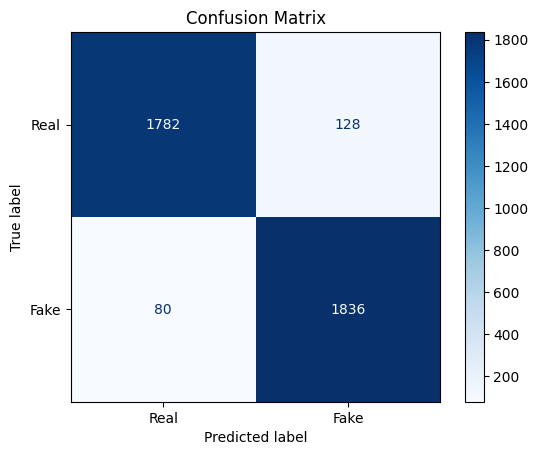

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_with_metrics(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            y_true.extend(data.y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))

    #  Visual Display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


evaluate_with_metrics(model, test_loader)



In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(model, loader):
    model.eval()
    y_true = []
    y_probs = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            prob = F.softmax(out, dim=1)[:, 1]  # Probability of class 1 (Fake)
            y_probs.extend(prob.cpu().numpy())
            y_true.extend(data.y.cpu().numpy())

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Baseline
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


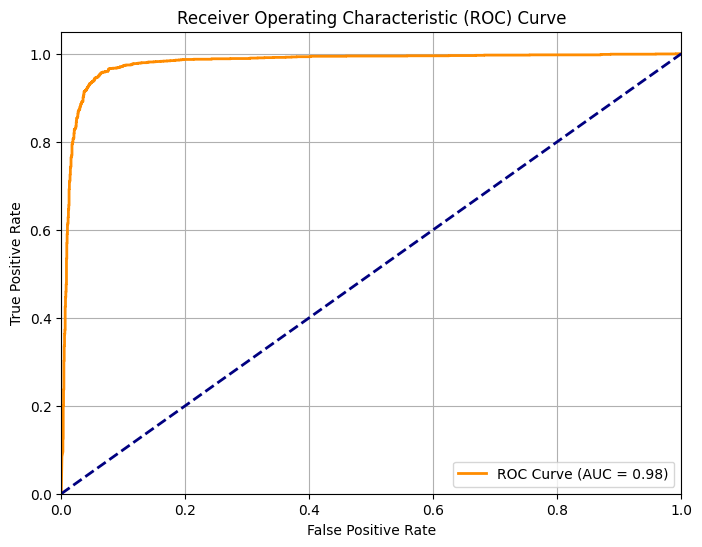

In [ ]:
plot_roc_auc(model, test_loader)
